In [1]:
#create 64 60*60 squares from a 480*480 image chess board
import cv2
import os

# Base directory paths
base_dir = "./augmented_train_images/board_and_fen_original/"
output_dir = "chess_images/squares/"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function to resize the image to 480x480 if needed
def resize_image_if_needed(image):
    # Check if the image is not 480x480
    if image.shape[0] != 480 or image.shape[1] != 480:
        # print(f"Resizing image to 480x480...")
        image = cv2.resize(image, (480, 480))
    return image

# Function to divide the board into 8x8 squares
def split_chessboard(image_path, output_subfolder, board_name):
    image = cv2.imread(image_path)
    image = resize_image_if_needed(image)  # Ensure the image is 480x480
    step = 60  # Each square is 60x60
    # Create a specific folder for each board inside the respective subfolder
    board_output_dir = os.path.join(output_subfolder, board_name)
    os.makedirs(board_output_dir, exist_ok=True)
    for i in range(8):
        for j in range(8):
            square = image[i * step:(i + 1) * step, j * step:(j + 1) * step]
            square_name = f"r{i}_c{j}.jpg"
            cv2.imwrite(os.path.join(board_output_dir, square_name), square)

# Process all images in all subfolders
for subfolder in os.listdir(base_dir):
    subfolder_path = os.path.join(base_dir, subfolder)
    if os.path.isdir(subfolder_path):  # Ensure it's a directory
        # Create corresponding output subfolder
        output_subfolder = os.path.join(output_dir, subfolder)
        os.makedirs(output_subfolder, exist_ok=True)
        for image_file in os.listdir(subfolder_path):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                board_name = os.path.splitext(image_file)[0]
                split_chessboard(os.path.join(subfolder_path, image_file), output_subfolder, board_name)


In [6]:
#labeling each square by looking at bw_fen and write in csv for each square

import os
import csv

# Paths
base_dir = "augmented_train_images/board_and_fen_train_20images/"
output_dir = "chess_images/labels/"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function to parse FEN and generate labels
def parse_fen(fen, output_subfolder, board_name):
    rows = fen.strip().split("/")
    for row_idx, row in enumerate(rows):
        col_idx = 0
        for char in row:
            if char.isdigit():
                # Empty squares
                for _ in range(int(char)):
                    square_name = f"r{row_idx}_c{col_idx}.csv"
                    square_output_dir = os.path.join(output_subfolder, board_name)
                    os.makedirs(square_output_dir, exist_ok=True)
                    with open(os.path.join(square_output_dir, square_name), "w", newline="") as csvfile:
                        writer = csv.writer(csvfile)
                        writer.writerow(["label"])
                        writer.writerow(["none"])  # Empty square
                    col_idx += 1
            else:
                # Black ('b') or White ('w') piece
                square_name = f"r{row_idx}_c{col_idx}.csv"
                label = "black" if char == "b" else "white"
                square_output_dir = os.path.join(output_subfolder, board_name)
                os.makedirs(square_output_dir, exist_ok=True)
                with open(os.path.join(square_output_dir, square_name), "w", newline="") as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow(["label"])
                    writer.writerow([label])
                col_idx += 1

# Process each subfolder
for subfolder in os.listdir(base_dir):
    subfolder_path = os.path.join(base_dir, subfolder)
    if os.path.isdir(subfolder_path):  # Ensure it's a directory
        output_subfolder = os.path.join(output_dir, subfolder)
        os.makedirs(output_subfolder, exist_ok=True)
        for file in os.listdir(subfolder_path):
            if file == "bw_board.fen":
                with open(os.path.join(subfolder_path, file), "r") as fen_file:
                    fen = fen_file.read()
                # Parse the FEN and generate labels for each board
                board_name = os.path.splitext(file)[0]
                parse_fen(fen, output_subfolder, board_name)



In [8]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage import exposure
import os
import csv
import re

# Base directory paths
squares_dir = "chess_images/squares/"
labels_dir = "chess_images/labels/"
output_file = "chess_images/prepared_data/hog_svm_data.npy"  # Final dataset file

def extract_hog_features(image_path):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize image to a consistent size (60x60)
    image = cv2.resize(image, (60, 60))

    # Compute HOG features (no need for multichannel argument)
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), visualize=True)
    
    # Return the feature descriptor (fd)
    return fd

# Function to load labels from a CSV file
def load_label(labels_dir, subfolder, row, col):
    label_path = os.path.join(labels_dir, subfolder, "bw_board", f"r{row}_c{col}.csv")
    try:
        with open(label_path, "r") as file:
            reader = csv.reader(file)
            next(reader)  # Skip header
            return next(reader)[0]  # Return the label ("white", "black", or "none")
    except FileNotFoundError:
        print(f"Label not found: {label_path}")
        return "none"

# Function to parse row and column from filenames
def parse_row_col(filename):
    match = re.match(r"r(\d+)_c(\d+)", filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    else:
        raise ValueError(f"Filename format error: {filename}")

# Prepare the dataset
features = []
labels = []

# Loop through all folders and boards
for subfolder in os.listdir(squares_dir):
    subfolder_path = os.path.join(squares_dir, subfolder)
    if os.path.isdir(subfolder_path):
        for board_folder in os.listdir(subfolder_path):
            board_path = os.path.join(subfolder_path, board_folder)
            if os.path.isdir(board_path):
                for square_image in os.listdir(board_path):
                    if square_image.endswith(".jpg"):
                        image_path = os.path.join(board_path, square_image)
                        
                        try:
                            # Parse row and column from the filename
                            row, col = parse_row_col(square_image)
                        except ValueError as e:
                            print(e)
                            continue
                        
                        # Extract HOG features and load labels
                        features.append(extract_hog_features(image_path))
                        labels.append(load_label(labels_dir, subfolder, row, col))

# Convert features and labels into numpy arrays for SVM training
X = np.array(features)

label_mapping = {"white": 1, "black": -1, "none"    : 0}
y = np.array([label_mapping[label] for label in labels])

# Save the dataset as a .npy file
np.save(output_file, {"features": X, "labels": y})

print(f"Data preparation complete. Saved to {output_file}.")


Data preparation complete. Saved to chess_images/prepared_data/hog_svm_data.npy.


In [10]:
import cv2
import numpy as np
from skimage import exposure
import os
import csv
import re

# Base directory paths
squares_dir = "chess_images/squares/"
labels_dir = "chess_images/labels/"
output_file = "chess_images/prepared_data/hsv_svm_data.npy"  # Final dataset file

def extract_color_features(image_path, bins=16):
    """Extracts HSV color histograms from an image."""
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Compute histograms for each channel (H, S, V)
    h_hist = cv2.calcHist([hsv_image], [0], None, [bins], [0, 180])  # Hue
    s_hist = cv2.calcHist([hsv_image], [1], None, [bins], [0, 256])  # Saturation
    v_hist = cv2.calcHist([hsv_image], [2], None, [bins], [0, 256])  # Value

    # Normalize histograms
    h_hist = cv2.normalize(h_hist, h_hist).flatten()
    s_hist = cv2.normalize(s_hist, s_hist).flatten()
    v_hist = cv2.normalize(v_hist, v_hist).flatten()

    # Concatenate histograms into a feature vector
    feature_vector = np.concatenate((h_hist, s_hist, v_hist))
    
    return feature_vector

# Function to load labels from a CSV file
def load_label(labels_dir, subfolder, row, col):
    label_path = os.path.join(labels_dir, subfolder, "bw_board", f"r{row}_c{col}.csv")
    try:
        with open(label_path, "r") as file:
            reader = csv.reader(file)
            next(reader)  # Skip header
            return next(reader)[0]  # Return the label ("white", "black", or "none")
    except FileNotFoundError:
        print(f"Label not found: {label_path}")
        return "none"

# Function to parse row and column from filenames
def parse_row_col(filename):
    match = re.match(r"r(\d+)_c(\d+)", filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    else:
        raise ValueError(f"Filename format error: {filename}")

# Prepare the dataset
features = []
labels = []

# Loop through all folders and boards
for subfolder in os.listdir(squares_dir):
    subfolder_path = os.path.join(squares_dir, subfolder)
    if os.path.isdir(subfolder_path):
        for board_folder in os.listdir(subfolder_path):
            board_path = os.path.join(subfolder_path, board_folder)
            if os.path.isdir(board_path):
                for square_image in os.listdir(board_path):
                    if square_image.endswith(".jpg"):
                        image_path = os.path.join(board_path, square_image)
                        
                        try:
                            # Parse row and column from the filename
                            row, col = parse_row_col(square_image)
                        except ValueError as e:
                            print(e)
                            continue
                        
                        # Extract HSV color features and load labels
                        features.append(extract_color_features(image_path))
                        labels.append(load_label(labels_dir, subfolder, row, col))

# Convert features and labels into numpy arrays for SVM training
X = np.array(features)

label_mapping = {"white": 1, "black": -1, "none": 0}
y = np.array([label_mapping[label] for label in labels])

# Save the dataset as a .npy file
np.save(output_file, {"features": X, "labels": y})

print(f"Data preparation complete. Saved to {output_file}.")

Data preparation complete. Saved to chess_images/prepared_data/hsv_svm_data.npy.


In [18]:
#HSV MODEL

#K Fold and Save Model
import numpy as np
import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Load dataset
data = np.load("chess_images/prepared_data/hsv_svm_data.npy", allow_pickle=True).item()
X, y = data["features"], data["labels"]

# Define models
models = {
    "HSV SVM": SVC(kernel="linear"),
    "HSV Random Forest": RandomForestClassifier(n_estimators=100),
}

# Use Stratified K-Fold (better for classification tasks)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for each model and save the best one
best_model = None
best_score = 0

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    mean_score = scores.mean()
    print(f"{name}: Mean Accuracy = {mean_score:.4f}, Std Dev = {scores.std():.4f}")

    # Train model on the full dataset before saving
    model.fit(X, y)
    model_path = f"chess_images/prepared_data/{name.lower().replace(' ', '_')}_model.pkl"
    joblib.dump(model, model_path)
    print(f"Saved {name} model to {model_path}")

    # Track the best model
    if mean_score > best_score:
        best_score = mean_score
        best_model = model

# Save the best model separately
best_model_path = "chess_images/prepared_data/hsv_best_model.pkl"
joblib.dump(best_model, best_model_path)
print(f"Best model saved to {best_model_path}")


HSV SVM: Mean Accuracy = 0.9987, Std Dev = 0.0001
Saved HSV SVM model to chess_images/prepared_data/hsv_svm_model.pkl
HSV Random Forest: Mean Accuracy = 0.9999, Std Dev = 0.0001
Saved HSV Random Forest model to chess_images/prepared_data/hsv_random_forest_model.pkl
Best model saved to chess_images/prepared_data/hsv_best_model.pkl


In [20]:
#HOG MODEL

#K Fold and Save Model
import numpy as np
import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Load dataset
data = np.load("chess_images/prepared_data/hog_svm_data.npy", allow_pickle=True).item()
X, y = data["features"], data["labels"]

# Define models
models = {
    "HOG SVM": SVC(kernel="linear"),
    "HOG Random Forest": RandomForestClassifier(n_estimators=100),
}

# Use Stratified K-Fold (better for classification tasks)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for each model and save the best one
best_model = None
best_score = 0

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    mean_score = scores.mean()
    print(f"{name}: Mean Accuracy = {mean_score:.4f}, Std Dev = {scores.std():.4f}")

    # Train model on the full dataset before saving
    model.fit(X, y)
    model_path = f"chess_images/prepared_data/{name.lower().replace(' ', '_')}_model.pkl"
    joblib.dump(model, model_path)
    print(f"Saved {name} model to {model_path}")

    # Track the best model
    if mean_score > best_score:
        best_score = mean_score
        best_model = model

# Save the best model separately
best_model_path = "chess_images/prepared_data/hog_best_model.pkl"
joblib.dump(best_model, best_model_path)
print(f"Best model saved to {best_model_path}")


HOG SVM: Mean Accuracy = 0.9678, Std Dev = 0.0036
Saved HOG SVM model to chess_images/prepared_data/hog_svm_model.pkl
HOG Random Forest: Mean Accuracy = 0.9833, Std Dev = 0.0015
Saved HOG Random Forest model to chess_images/prepared_data/hog_random_forest_model.pkl
Best model saved to chess_images/prepared_data/hog_best_model.pkl


In [13]:
import cv2
import numpy as np
from skimage import exposure
import os
import csv
import re
import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Base directory paths
squares_dir = "chess_images/squares/"
labels_dir = "chess_images/labels/"
output_file = "chess_images/prepared_data/bw_hsv_svm_data.npy"  # Final dataset file

def extract_color_features(image_path, bins=16):
    """Extracts HSV color histograms from an image."""
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    h_hist = cv2.calcHist([hsv_image], [0], None, [bins], [0, 180])  # Hue
    s_hist = cv2.calcHist([hsv_image], [1], None, [bins], [0, 256])  # Saturation
    v_hist = cv2.calcHist([hsv_image], [2], None, [bins], [0, 256])  # Value

    h_hist = cv2.normalize(h_hist, h_hist).flatten()
    s_hist = cv2.normalize(s_hist, s_hist).flatten()
    v_hist = cv2.normalize(v_hist, v_hist).flatten()

    return np.concatenate((h_hist, s_hist, v_hist))

def load_label(labels_dir, subfolder, row, col):
    """Loads labels from CSV and ignores empty squares."""
    label_path = os.path.join(labels_dir, subfolder, "bw_board", f"r{row}_c{col}.csv")
    try:
        with open(label_path, "r") as file:
            reader = csv.reader(file)
            next(reader)  # Skip header
            label = next(reader)[0]  # "white" or "black"
            return label if label in {"white", "black"} else None  # Ignore "none"
    except FileNotFoundError:
        print(f"Label not found: {label_path}")
        return None

def parse_row_col(filename):
    """Extracts row and column indices from filename."""
    match = re.match(r"r(\d+)_c(\d+)", filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    else:
        raise ValueError(f"Filename format error: {filename}")

features, labels = [], []

# Loop through dataset directories
for subfolder in os.listdir(squares_dir):
    subfolder_path = os.path.join(squares_dir, subfolder)
    if os.path.isdir(subfolder_path):
        for board_folder in os.listdir(subfolder_path):
            board_path = os.path.join(subfolder_path, board_folder)
            if os.path.isdir(board_path):
                for square_image in os.listdir(board_path):
                    if square_image.endswith(".jpg"):
                        image_path = os.path.join(board_path, square_image)
                        try:
                            row, col = parse_row_col(square_image)
                        except ValueError as e:
                            print(e)
                            continue
                        feature_vector = extract_color_features(image_path)
                        label = load_label(labels_dir, subfolder, row, col)
                        if label is not None:
                            features.append(feature_vector)
                            labels.append(label)

X = np.array(features)
label_mapping = {"white": 1, "black": -1}  # No "none"
y = np.array([label_mapping[label] for label in labels])

np.save(output_file, {"features": X, "labels": y})
print(f"Data preparation complete. Saved to {output_file}.")



Data preparation complete. Saved to chess_images/prepared_data/bw_hsv_svm_data.npy.


In [19]:
#HOG MODEL

#K Fold and Save Model
import numpy as np
import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Load dataset
data = np.load("chess_images/prepared_data/bw_hsv_svm_data.npy", allow_pickle=True).item()
X, y = data["features"], data["labels"]

# Define models
models = {
    "BW HSV SVM": SVC(kernel="linear"),
    "BW HSV Random Forest": RandomForestClassifier(n_estimators=100),
}

# Use Stratified K-Fold (better for classification tasks)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for each model and save the best one
best_model = None
best_score = 0

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    mean_score = scores.mean()
    print(f"{name}: Mean Accuracy = {mean_score:.4f}, Std Dev = {scores.std():.4f}")

    # Train model on the full dataset before saving
    model.fit(X, y)
    model_path = f"chess_images/prepared_data/{name.lower().replace(' ', '_')}_model.pkl"
    joblib.dump(model, model_path)
    print(f"Saved {name} model to {model_path}")

    # Track the best model
    if mean_score > best_score:
        best_score = mean_score
        best_model = model

# Save the best model separately
best_model_path = "chess_images/prepared_data/bw_hsv_best_model.pkl"
joblib.dump(best_model, best_model_path)
print(f"Best model saved to {best_model_path}")


BW HSV SVM: Mean Accuracy = 0.9995, Std Dev = 0.0003
Saved BW HSV SVM model to chess_images/prepared_data/bw_hsv_svm_model.pkl
BW HSV Random Forest: Mean Accuracy = 0.9999, Std Dev = 0.0001
Saved BW HSV Random Forest model to chess_images/prepared_data/bw_hsv_random_forest_model.pkl
Best model saved to chess_images/prepared_data/bw_hsv_best_model.pkl


Random Forest: Mean Accuracy = 0.9999, Std Dev = 0.0002
Saved Random Forest model to chess_images/prepared_data/bw_hsv_random_forest_model_test.pkl
Evaluation Metrics:
Accuracy: 1.0000
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1552
           1       1.00      1.00      1.00      1552

    accuracy                           1.00      3104
   macro avg       1.00      1.00      1.00      3104
weighted avg       1.00      1.00      1.00      3104



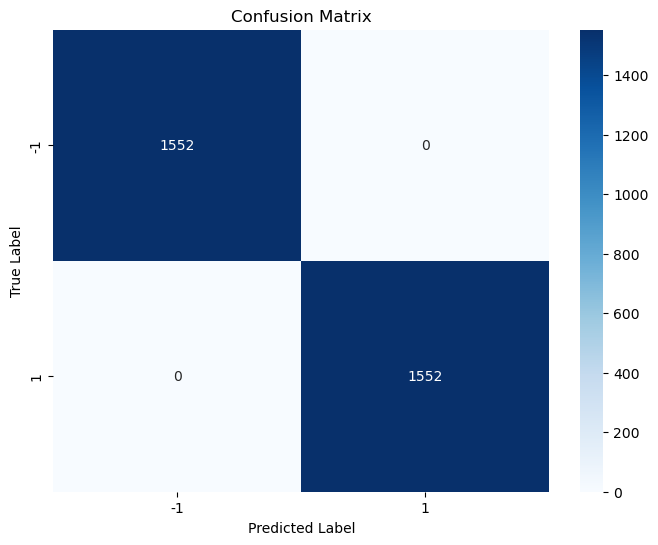

In [3]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Load dataset
data = np.load("chess_images/prepared_data/bw_hsv_svm_data.npy", allow_pickle=True).item()
X, y = data["features"], data["labels"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Use Stratified K-Fold (better for classification tasks)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")
mean_score = scores.mean()
print(f"Random Forest: Mean Accuracy = {mean_score:.4f}, Std Dev = {scores.std():.4f}")

# Train model on full training dataset
model.fit(X_train, y_train)

# Save model
model_path = "chess_images/prepared_data/bw_hsv_random_forest_model_test.pkl"
joblib.dump(model, model_path)
print(f"Saved Random Forest model to {model_path}")

# Evaluate model on test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [16]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage import exposure
import os
import csv
import re

# Base directory paths
squares_dir = "chess_images/squares/"
labels_dir = "chess_images/labels/"
output_file = "chess_images/prepared_data/tf_hog_svm_data.npy"  # Final dataset file

def extract_hog_features(image_path):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize image to a consistent size (60x60)
    image = cv2.resize(image, (60, 60))

    # Compute HOG features (no need for multichannel argument)
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), visualize=True)
    
    # Return the feature descriptor (fd)
    return fd

# Function to load labels from a CSV file
def load_label(labels_dir, subfolder, row, col):
    label_path = os.path.join(labels_dir, subfolder, "bw_board", f"r{row}_c{col}.csv")
    try:
        with open(label_path, "r") as file:
            reader = csv.reader(file)
            next(reader)  # Skip header
            label = next(reader)[0]  # Get the label

            # Convert label to "none" or "occupy"
            return "occupy" if label in {"white", "black"} else "none"

    except FileNotFoundError:
        print(f"Label not found: {label_path}")
        return "none"

# Function to parse row and column from filenames
def parse_row_col(filename):
    match = re.match(r"r(\d+)_c(\d+)", filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    else:
        raise ValueError(f"Filename format error: {filename}")

# Prepare the dataset
features = []
labels = []

# Loop through all folders and boards
for subfolder in os.listdir(squares_dir):
    subfolder_path = os.path.join(squares_dir, subfolder)
    if os.path.isdir(subfolder_path):
        for board_folder in os.listdir(subfolder_path):
            board_path = os.path.join(subfolder_path, board_folder)
            if os.path.isdir(board_path):
                for square_image in os.listdir(board_path):
                    if square_image.endswith(".jpg"):
                        image_path = os.path.join(board_path, square_image)
                        
                        try:
                            # Parse row and column from the filename
                            row, col = parse_row_col(square_image)
                        except ValueError as e:
                            print(e)
                            continue
                        
                        # Extract HOG features and load labels
                        features.append(extract_hog_features(image_path))
                        labels.append(load_label(labels_dir, subfolder, row, col))

# Convert features and labels into numpy arrays for SVM training
X = np.array(features)

# Label mapping for binary classification
label_mapping = {"occupy": 1, "none": 0}
y = np.array([label_mapping[label] for label in labels])

# Save the dataset as a .npy file
np.save(output_file, {"features": X, "labels": y})

print(f"Data preparation complete. Saved to {output_file}.")


Data preparation complete. Saved to chess_images/prepared_data/tf_hog_svm_data.npy.


In [17]:
#HOG MODEL

#K Fold and Save Model
import numpy as np
import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Load dataset
data = np.load("chess_images/prepared_data/tf_hog_svm_data.npy", allow_pickle=True).item()
X, y = data["features"], data["labels"]

# Define models
models = {
    "TF HOG SVM": SVC(kernel="linear"),
    "TF HOG Random Forest": RandomForestClassifier(n_estimators=100),
}

# Use Stratified K-Fold (better for classification tasks)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for each model and save the best one
best_model = None
best_score = 0

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    mean_score = scores.mean()
    print(f"{name}: Mean Accuracy = {mean_score:.4f}, Std Dev = {scores.std():.4f}")

    # Train model on the full dataset before saving
    model.fit(X, y)
    model_path = f"chess_images/prepared_data/{name.lower().replace(' ', '_')}_model.pkl"
    joblib.dump(model, model_path)
    print(f"Saved {name} model to {model_path}")

    # Track the best model
    if mean_score > best_score:
        best_score = mean_score
        best_model = model

# Save the best model separately
best_model_path = "chess_images/prepared_data/tf_hog_best_model.pkl"
joblib.dump(best_model, best_model_path)
print(f"Best model saved to {best_model_path}")


TF HOG SVM: Mean Accuracy = 0.9996, Std Dev = 0.0002
Saved TF HOG SVM model to chess_images/prepared_data/tf_hog_svm_model.pkl
TF HOG Random Forest: Mean Accuracy = 0.9987, Std Dev = 0.0002
Saved TF HOG Random Forest model to chess_images/prepared_data/tf_hog_random_forest_model.pkl
Best model saved to chess_images/prepared_data/tf_hog_best_model.pkl


Random Forest: Mean Accuracy = 0.9986, Std Dev = 0.0004
Saved Random Forest model to chess_images/prepared_data/tf_hog_random_forest_model_test.pkl
Evaluation Metrics:
Accuracy: 0.9986
F1 Score: 0.9986
Precision: 0.9986
Recall: 0.9986
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3104
           1       1.00      1.00      1.00      3104

    accuracy                           1.00      6208
   macro avg       1.00      1.00      1.00      6208
weighted avg       1.00      1.00      1.00      6208



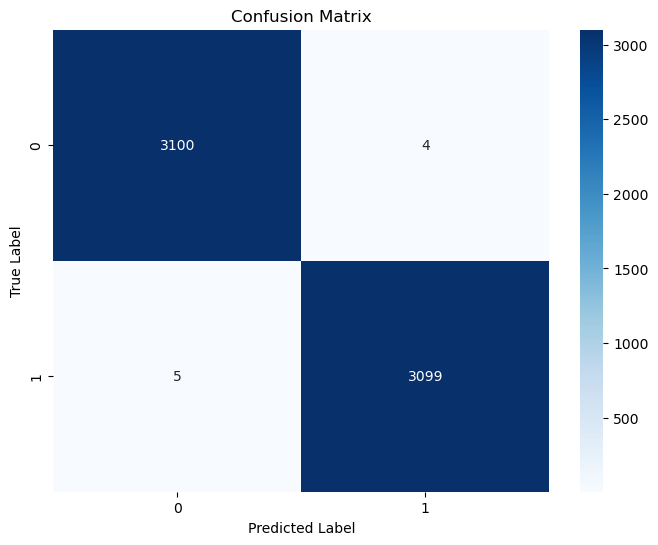

In [4]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Load dataset
data = np.load("chess_images/prepared_data/tf_hog_svm_data.npy", allow_pickle=True).item()
X, y = data["features"], data["labels"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Use Stratified K-Fold (better for classification tasks)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")
mean_score = scores.mean()
print(f"Random Forest: Mean Accuracy = {mean_score:.4f}, Std Dev = {scores.std():.4f}")

# Train model on full training dataset
model.fit(X_train, y_train)

# Save model
model_path = "chess_images/prepared_data/tf_hog_random_forest_model_test.pkl"
joblib.dump(model, model_path)
print(f"Saved Random Forest model to {model_path}")

# Evaluate model on test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
